## Multiple linear regression (重回帰）

Week1で行った、単回帰の説明変数が複数になっただけ。

Notation

n : 被説明変数(feature)の数

m : データ数（一般的な統計学の文脈だとNがデータ数なので混乱に注意）

y : 被説明変数 [ m, 1 ] vector

X : 説明変数 [ m, n ] matrix

theta : パラメタ（重み）[ n, 1 ] vector

$$ y = X \theta + \epsilon$$

で誤差（ε）を最小にするパラメタ（θ）を見つける問題。

Week2では、この問題を数値的手法、解析的手法の両方で解く。


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [15]:
data = np.loadtxt('C:/Users/a5136731/Desktop/tmpSugi/ex1/ex1data2.txt',delimiter=',',dtype='float')
y = data[:,(2)]
y = y[:, np.newaxis]
X = data[:,(0,1)]
m = X.shape[0]

## Feature scaling
スケーリング前のデータの統計量

In [16]:
def basicStat(X):
    N = np.size(X,0)
    nameList = np.size(X,1) * ['A']
    for i in range(0, np.size(X,1)):
        nameList[i] = 'X' + str(i)
    Avg = np.mean(X,0)
    
    df = pd.DataFrame({'N' : np.shape(X)[0],
                       'Avg' : np.mean(X,0),
                       'Med' : np.median(X,0),
                       'Std' : np.std(X,0),
                      },
                     columns = ['N', 'Avg','Med','Std'],
                     index = nameList)
    return df

df = basicStat(X)
df      

,N,Avg,Med,Std
X0,47,2000.680851,1888.0,786.202619
X1,47,3.170213,3.0,0.752843


## Feature scaling
スケーリング後のデータの統計量

### Feature scaling
Scalingとは、データの範囲をそろえることを指す。
スケールがそろっていない場合、Gradient decentの様な繰り返し計算を行う場合に、
変数の大きさが収束に影響を与えてしまうのを防ぐ目的がある。

\begin{align*}& \; & \theta_j := \theta_j - \alpha \frac{1}{m} \sum\limits_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) \cdot x_j^{(i)} \; & \text{for j := 0...n}\end{align*}


Scalingには複数の方法があるが、よく使われるのは2つ

Standardization(標準化)

$${x^{(i)}_{\mathrm{std}} = \frac{x^{(i)} - \mu}{\sigma}}$$

データを、標準正規分布に従うように変更する。
正規分布なので統計的に扱いやすくなるが、外れ値が大きい場合、分散が過大推定されるので注意

Normalization（正規化）
$${x^{(i)}_{\mathrm{norm}} = \frac{x^{(i)} - x_{\mathrm{min}}}{x_{\mathrm{max}} - x_\mathrm{min}}
}$$

データを無次元化して、一定のレンジに収まるようにする。
（外れ値の外れ方も保存される）

参考
http://sebastianraschka.com/Articles/2014_about_feature_scaling.html



In [17]:
def featureNormalize(X):
    X_norm = X
    mu = np.zeros((1,X.shape[1]))
    sigma = np.zeros((1,X.shape[1]))
    mu = np.average(X_norm, axis = 0)
    sigma = np.std(X_norm, axis = 0)
    X_norm = ( X_norm - mu )/sigma
    return [X_norm, mu, sigma]

X, mu, sigma = featureNormalize(X)
df = basicStat(X)
df




,N,Avg,Med,Std
X0,47,9.448707e-18,-0.143323,1.0
X1,47,2.710598e-16,-0.226093,1.0


## Gradient descent (最急降下法)

最小（最大）値問題を数値的（⇔解析的）に解く手法の一つ。

一般的にベクトルθを引数とする関数fに対して、以下の更新ルールでθを求める。

$$\theta := \theta - \alpha*\frac{\partial f}{\partial \theta}  $$

重回帰モデルにおいては、コスト関数は二乗誤差、すなわち↓を最小にするパラメタを求める。

$$J(\theta) = \dfrac {1}{2m} \displaystyle \sum_{i=1}^m \left (h_\theta (x^{(i)}) - y^{(i)} \right)^2$$

ここで
$$\frac{\partial J(\theta)}{\partial \theta_k} =　\dfrac {1}{m} * \sum\limits_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) \cdot x_k^{(i)} $$

なので、それぞれのθに対して、以下のルールで収束するまでθを更新する。

\begin{align*}& \; & \theta_j := \theta_j - \alpha \frac{1}{m} \sum\limits_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) \cdot x_j^{(i)} \; & \text{for j := 0...n}\end{align*}





和記号を使わずに、すべて行列で表現しようとすると、

$$J(\theta) = \dfrac {1}{2m} (\theta X - y)^{T} (\theta X - y)$$


\begin{align*}\nabla J(\theta)= \frac 1m X^{T} (\theta X - y) \newline\end{align*}

ここで

$$\nabla J(\theta)  = \begin{bmatrix}\frac{\partial J(\theta)}{\partial \theta_0}   \newline \frac{\partial J(\theta)}{\partial \theta_1}   \newline \vdots   \newline \frac{\partial J(\theta)}{\partial \theta_n} \end{bmatrix}$$

これにより、

$$\theta := \theta - \alpha \nabla J(\theta)$$


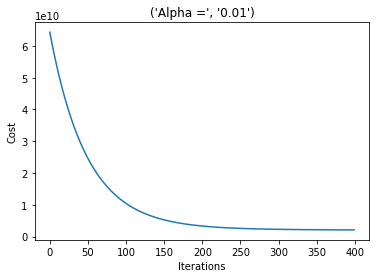

In [5]:
def gradientDescent(X, y, theta, alpha, num_iters):
    m = len(y)
    J_history = np.zeros((num_iters,1))
    for i in range(0, num_iters):
        theta = theta - (alpha/m) * np.transpose(X).dot(X.dot(theta) - y)
        J_history[i] = computeCost(X,y,theta)
    return [theta, J_history]

def computeCost(X, y, theta):
    m = len(y)
    tmp = ( X.dot(theta) - y )
    J = (1/(2*m)) * np.transpose(tmp).dot(tmp)
    return J

    
'load data'
data = np.loadtxt('C:/Users\main/Documents/MATLAB/ex1/ex1data2.txt',delimiter=',',dtype='float')
y = (data[:,(2)])
' this bit was hard to find the way..'
y = y[:, np.newaxis]
X = data[:,(0,1)]
m = len(X)
'normalize data'
X, mu, sigma = featureNormalize(X)
'add intercept'
X = np.c_[np.ones(m),X]

'gradient descent'
alpha = 0.01
num_iters = 400
theta = np.zeros((3,1))
theta, J_history = gradientDescent(X, y, theta, alpha, num_iters)

plt.plot(range(0,num_iters), J_history)
plt.xlabel('Iterations')
plt.ylabel('Cost')
titleStr = 'Alpha =', str(alpha)
plt.title(titleStr)



## 正規方程式 (Normal Equation)

$$ y = X \theta + \epsilon$$

は解析解をもつ（(X'X)の逆行列が存在する場合）

$$\theta = (X^{\mathrm{T}}X)^{-1}X^{\mathrm{T}}y$$

逆行列が計算しない場合は、一般化逆行列（pythonではnumpy.linalg.pinv)で計算可能。

ただし、逆行列が計算できないのは

1. Xの要素が線形関係にある
2. データ数に比べて、パラメタの数が大きすぎる

場合。なので、計算ができるからと言って、安易に一般化逆行列を使わないほうがいい。
2はすぐに気づくはず。1に注意。

単純な重回帰であれば、iterationも不要だし、ahlpaも決めなくてもよいので、解析解の方がよい。
パラメータ数を超えたら数値解の方が早くなる。


In [6]:
def normalEq(X,y):
    theta = np.linalg.inv(np.transpose(X).dot(X)) 
    theta = theta.dot(np.transpose(X).dot(y))
    return theta

'normal equation'
data = np.loadtxt('C:/Users/a5136731/Desktop/tmpSugi/ex1/ex1data2.txt',delimiter=',',dtype='float')
y = (data[:,(2)])
' this bit was hard..'
y = y[:, np.newaxis]
X = data[:,(0,1)]
X = np.c_[np.ones(m),X]

theta = normalEq(X,y);
